Add Oversampling

In [2]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
#import tensorflow.keras
from tensorflow.keras import backend as K

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3




from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


#from tensorflow.nn import sigmoid_cross_entropy_with_logits



In [3]:
tf.test.is_gpu_available()

True

In [4]:
tf.test.is_built_with_cuda()

True

## Image Path

In [5]:
path_train_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [6]:
path_test_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'

In [7]:
def get_number_of_files(path, data_name):
    no =  len(os.listdir(path))
    print (f'The {data_name} contains {no} files.')

In [8]:
def get_size_directory(path, data_name):
    size = round(sum([os.path.getsize(f'{path}'+ f'{file}') for file in os.listdir(path)])*(10**-9), 2)
    print (f'The size of the {data_name} is {size} GB.')

In [9]:
print('***TRAIN DATA***')
get_size_directory(path_train_data, 'Training Data')
get_number_of_files(path_train_data, 'Training Data')

print('*******')

print('***TEST DATA***')
get_size_directory(path_test_data, 'Testing Data')
get_number_of_files(path_test_data, 'Testing Data')

print('*******')

print(f'We have {round(len(os.listdir(path_train_data))/len(os.listdir(path_test_data)),1)} times more train than test data.' )

***TRAIN DATA***
The size of the Training Data is 395.19 GB.
The Training Data contains 752803 files.
*******
***TEST DATA***
The size of the Testing Data is 63.64 GB.
The Testing Data contains 121232 files.
*******
We have 6.2 times more train than test data.


## Meta Data

In [10]:

train_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
# Test submission as test 
test_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

In [11]:
train_meta_df_shape = train_meta_df.shape
test_meta_df_shape = test_meta_df.shape

In [12]:
print(train_meta_df_shape)
print(test_meta_df_shape)

(4516842, 2)
(727392, 2)


## Parameters

In [13]:

# Seed
SEED = 11
np.random.seed(SEED)


# Constants
TEST_SIZE = 0.2
HEIGHT = 256 #VGG 16 has 256x256
WIDTH = 256
CHANNELS = 3
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 8
SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Folders
#DATA_DIR = '/kaggle/input/rsna-intracranial-hemorrhage-detection/'
PATH_TEST_DATA = path_test_data
PATH_TRAIN_DATA = path_train_data

In [14]:
def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image

def rescale_window(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    brain_img = set_manual_window(rescaled_image, 40, 80)
    subdural_img = set_manual_window(rescaled_image, 80, 200)
    soft_img =set_manual_window(rescaled_image, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def load_dicom_dataset(path, SHAPE):
    dataset = pydicom.dcmread(path)
    try:
        img = rescale_window(dataset)
    except:
        img = np.zeros(SHAPE)
    return img

In [15]:
    
        
# Generators
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, labels, batch_size = 16, img_size = SHAPE, img_dir = PATH_TRAIN_DATA, augment = False, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.augment = augment
        self.on_epoch_end()

    def __len__(self): #Number of Batches per Epoch
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index): #Generates one Batch of Data
        #indices of Batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indices)
        return X, Y

    def augmentor(self, image):
        augment_img = iaa.Sequential([ iaa.Fliplr(0.25),
                                iaa.Flipud(0.10)], random_order = True)       
            
        image_aug = augment_img.augment_image(image)
        return image_aug

    def on_epoch_end(self): #Updates Indices after each Epoch
        self.indices = np.arange(len(self.ids))
        np.random.shuffle(self.indices)

    def __data_generation(self, indices): #Generates Data in Size of Batch Size
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            
            image = load_dicom_dataset(self.img_dir+ID+".dcm", SHAPE)
            if self.augment:
                X[i,] = self.augmentor(image)
            else:
                X[i,] = image
            Y[i,] = self.labels.iloc[index].values        
        return X, Y
    


   
    
    


In [16]:
class TestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset,batch_size = 16, img_size = SHAPE, img_dir = PATH_TEST_DATA, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indices)
        return X

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = load_dicom_dataset(self.img_dir+ID+".dcm", SHAPE)
            X[i,] = image              
        return X


## Preparing Meta Data Frames


In [17]:
def make_usable_df(df):
    label = df.Label.values
    new_df = df.ID.str.rsplit("_", n=1, expand=True)
    new_df.loc[:, "label"] = label
    new_df = new_df.rename({0: "id", 1: "subtype"}, axis=1)
    piv_df = pd.pivot_table(new_df, index="id", columns="subtype", values="label")
    
    return piv_df


Check for Dupicates:

In [18]:
train_meta_df.duplicated().sum()

24

In [19]:
train_meta_df.drop_duplicates(inplace = True)

In [20]:
train_meta_df_shape[0] - train_meta_df.shape[0] == 24

True

Make usable Data Frame:

In [21]:
train_df = make_usable_df(train_meta_df)
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0



Check for Duplicates:

In [22]:
test_meta_df.duplicated().sum()

0

Make usable Data Frame:

In [23]:
test_df = make_usable_df(test_meta_df)
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


## Oversampling Epidural Label

In [24]:
train_df['any'].value_counts()

0    644870
1    107933
Name: any, dtype: int64

In [25]:
any_df = train_df[train_df['any'] == 1]

In [26]:
train_df_oversampled = pd.concat([train_df, any_df])

In [27]:
train_df = train_df_oversampled

In [28]:
print('Train Shape: {}'.format(train_df.shape))


Train Shape: (860736, 6)


In [29]:
train_df['any'].value_counts()

0    644870
1    215866
Name: any, dtype: int64

# Train/ Val Split

## Multi Label Stratified Shuffel Splitter 
Cross Validaor with stratification on multiple labels:
https://github.com/trent-b/iterative-stratification

In [30]:
split_seed = 11
kfold = StratifiedKFold(n_splits=5, random_state=split_seed).split(np.arange(train_df.shape[0]), train_df["any"].values)

train_idx, val_idx = next(kfold)

# train_data = traindf.iloc[train_idx]
# dev_data = traindf.iloc[dev_idx]

# #train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
# print(train_data.shape)
# print(dev_data.shape)

In [31]:
train_idx.shape

(688588,)

In [32]:
val_idx.shape

(172148,)

## Custom Loan Functions

In [33]:
def np_multilabel_loss(y_true, y_pred, class_weights=None):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

def get_raw_xentropies(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    xentropies = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
    return -xentropies

# multilabel focal loss equals multilabel loss in case of alpha=0.5 and gamma=0 
def multilabel_focal_loss(class_weights=None, alpha=0.5, gamma=2):
    def mutlilabel_focal_loss_inner(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        xentropies = get_raw_xentropies(y_true, y_pred)

        # compute pred_t:
        y_t = tf.where(tf.equal(y_true,1), y_pred, 1.-y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha * tf.ones_like(y_true), (1-alpha) * tf.ones_like(y_true))

        # compute focal loss contributions
        focal_loss_contributions =  tf.multiply(tf.multiply(tf.pow(1-y_t, gamma), xentropies), alpha_t) 

        # our focal loss contributions have shape (n_samples, s_classes), we need to reduce with mean over samples:
        focal_loss_per_class = tf.reduce_mean(focal_loss_contributions, axis=0)

        # compute the overall loss if class weights are None (equally weighted):
        if class_weights is None:
            focal_loss_result = tf.reduce_mean(focal_loss_per_class)
        else:
            # weight the single class losses and compute the overall loss
            weights = tf.constant(class_weights, dtype=tf.float32)
            focal_loss_result = tf.reduce_sum(tf.multiply(weights, focal_loss_per_class))
            
        return focal_loss_result
    return mutlilabel_focal_loss_inner

## Make Model


In [34]:
SHAPE

(256, 256, 3)

In [36]:
def create_model():
    #K.clear_session()
    
    base_model = VGG19(weights = "imagenet", include_top=False, input_shape = SHAPE)
    #base_model.load_weights(filepath+'model.h5')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    y_pred = Dense(6, activation="sigmoid")(x)

    return Model(inputs = base_model.input, outputs = y_pred)

In [37]:

# Create Data Generators for Train and Valid
data_generator_train = TrainDataGenerator(train_df.iloc[train_idx], 
                                            train_df.iloc[train_idx], 
                                            TRAIN_BATCH_SIZE, 
                                            SHAPE,
                                            augment = True)
data_generator_val = TrainDataGenerator(train_df.iloc[val_idx], 
                                        train_df.iloc[val_idx], 
                                        VALID_BATCH_SIZE, 
                                        SHAPE,
                                        augment = False)

TRAIN_STEPS = int(len(data_generator_train) / TRAIN_BATCH_SIZE)

#Adding custom Layers 



vgg19_model = create_model()

for layer in vgg19_model.layers[:5]:
    layer.trainable = False



my_callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='../models/mymodels/vgg19_model3.h5', monitor='val_loss', save_best_only=True, verbose=1)]


# compile the model 
vgg19_model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["accuracy"])


        




# Train the model 
history = vgg19_model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        epochs = 50,
                        callbacks = my_callbacks,
                        verbose = 1,
                         use_multiprocessing = True)


Epoch 1/50
167/168 [============================>.] - ETA: 8s - loss: 0.3919 - accuracy: 0.8822 
Epoch 00001: val_loss improved from inf to 0.29502, saving model to ../models/mymodels/vgg19_model3.h5
168/168 [==============================] - 3660s 22s/step - loss: 0.3916 - accuracy: 0.8823 - val_loss: 0.2950 - val_accuracy: 0.9008
Epoch 2/50
167/168 [============================>.] - ETA: 1s - loss: 0.3258 - accuracy: 0.8981
Epoch 00002: val_loss did not improve from 0.29502
168/168 [==============================] - 1867s 11s/step - loss: 0.3258 - accuracy: 0.8980 - val_loss: 0.2970 - val_accuracy: 0.9008
Epoch 3/50
 25/168 [===>..........................] - ETA: 3:41 - loss: 0.3205 - accuracy: 0.8958

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/nvidia/conda/envs/nvidia-dsd-1.3/lib/python3.7/multiprocessing/conne

KeyboardInterrupt: 

In [34]:
vgg19_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

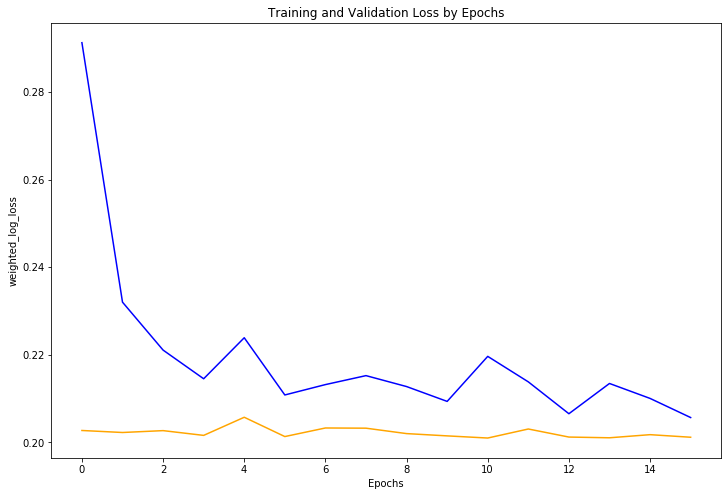

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Training and Validation Loss by Epochs')
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss');

In [70]:
# def predictions(test_df, model):    
#     test_preds = model.predict_generator(TestDataGenerator(test_df,TEST_BATCH_SIZE, SHAPE, PATH_TEST_DATA, verbose = 1))
#     return test_preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]


In [36]:
data_generator_test = TestDataGenerator(dataset = test_df, batch_size = TEST_BATCH_SIZE,img_size = SHAPE,
                                                        img_dir = PATH_TEST_DATA)

In [37]:
TEST_STEPS = int(len(data_generator_test) / TRAIN_BATCH_SIZE)

In [39]:
TEST_STEPS = int(test_df.shape[0] / TRAIN_BATCH_SIZE)

In [40]:
len(data_generator_test)

15154

In [41]:
preds = vgg19_model.predict_generator(generator = data_generator_test, 
                                      #steps = TEST_STEPS,
                                      verbose = 1,
                                      use_multiprocessing=True)

15154/15154 [==============================] - 1119s 74ms/step


In [42]:
preds.shape

(121232, 6)

In [43]:
test_df.shape

(121232, 6)

In [44]:
preds = preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]

In [45]:
def make_df(meta_data_df, predictions):
    df = pd.DataFrame(predictions, columns=meta_data_df.columns, index=meta_data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    return df

In [46]:
test_pred_df = make_df(test_df, preds)

In [47]:
test_pred_df = test_pred_df[['ID','Label']]

In [48]:
test_pred_df.to_csv('../data/output/submissions/submission_model_4.csv', index=False)

In [49]:
test_pred_df.shape

(727392, 2)

In [50]:
val_preds= vgg19_model.predict_generator(generator = data_generator_val, verbose = 1, use_multiprocessing=True)

2353/2353 [==============================] - 1439s 611ms/step


In [56]:
val_pred = val_preds[:train_df.iloc[val_idx].shape[0]]

In [57]:
val_pred_df = make_df(train_df.iloc[val_idx], val_pred)

In [58]:
val_pred_df = val_pred_df[['ID','Label']]

In [60]:
val_pred_df.shape

(903366, 2)

In [62]:
val_pred_df.to_csv('../data/output/submissions/val_pred_model_4.csv', index=False)